In [ ]:
# Here we again utilize the biblioshiny app to generate the csv for visualizing author impact
# documentation for that is here --> https://www.bibliometrix.org/home/index.php/layout/biblioshiny
# this script takes the resulting Rdata file and converts it into a dataframe in python

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
import pickle

In [6]:
M = pd.read_pickle("peds_spine_v1_from_R.pkl")

# Drop rows where 'AU' contains 'ANONYMOUS'
M = M[~M['AU'].str.contains('ANONYMOUS')]

# inspect a sample of the dataframe
M.sample(5)

,AU,DE,ID,C1,CR,AB,PA,affiliations,AR,EM,...,web.of.science.index,PY,RP,DB,J9,AU_UN,AU1_UN,AU_UN_NR,SR_FULL,SR
9878,JEA A;AL-OTIBI M;RUTKA JT;DRAKE JM;DIRKS PB;KU...,HOSPITAL FOR SICK CHILDREN; MEDICAL HISTORY; N...,BRAIN-STEM GLIOMAS; ARNOLD-CHIARI MALFORMATION...,"HUMPHREYS, RP (CORRESPONDING AUTHOR), UNIV TOR...","ALEXANDER E, 1974, J NEUROSURG, V41, P1, DOI 1...",THE TRADITION OF SELFLESS CHARITY FOR CHILDREN...,"JOURNALS DEPT, 2001 EVANS RD, CARY, NC 27513 USA",UNIVERSITY OF TORONTO,NaN,CNSURG@SICKKIDS.CA,...,SCIENCE CITATION INDEX EXPANDED (SCI-EXPANDED),2007,"HUMPHREYS, RP (CORRESPONDING AUTHOR), UNIV TOR...",ISI,NEUROSURGERY,UNIV TORONTO;UNIV TORONTO,UNIV TORONTO,NaN,"JEA A, 2007, NEUROSURGERY","JEA A, 2007, NEUROSURGERY"
8091,RORKE LB,PEDIATRIC NEUROPATHOLOGY; MALFORMATIONS; TUMORS,NEUROGENESIS; PERSPECTIVE; TUMORS,"RORKE, LB (CORRESPONDING AUTHOR), CHILDRENS HO...","BAILEY, 1926, CLASSIFICATION TUMOR; BIEGEL JA,...",THE CURRENT STATE OF KNOWLEDGE OF PEDIATRIC NE...,"175 FIFTH AVE, NEW YORK, NY 10010 USA",UNIVERSITY OF PENNSYLVANIA; PENNSYLVANIA MEDIC...,NaN,NaN,...,CONFERENCE PROCEEDINGS CITATION INDEX - SCIENC...,2000,"RORKE, LB (CORRESPONDING AUTHOR), CHILDRENS HO...",ISI,CHILDS NERV SYST,CHILDRENS HOSP PHILADELPHIA;CHILDRENS HOSP PHI...,CHILDRENS HOSP PHILADELPHIA,NaN,"RORKE LB, 2000, CHILDS NERV SYST","RORKE LB, 2000, CHILDS NERV SYST"
11157,KUO FC;WANG NH;HONG CZ,VISUAL; SENSORY; BALANCE; SCOLIOSIS,MUSCLE IMBALANCE; POSTURAL CONTROL; STABILITY;...,"KUO, FC (CORRESPONDING AUTHOR), HUNGKUANG UNIV...","AMARAL DG, 2000, PRINCIPLES NEURAL SC, P337; *...",STUDY DESIGN. A CROSS-SECTIONAL STUDY OF BALAN...,"TWO COMMERCE SQ, 2001 MARKET ST, PHILADELPHIA,...",HUNGKUANG UNIVERSITY,NaN,KFC@SUNRISE.HK.EDU.TW,...,SCIENCE CITATION INDEX EXPANDED (SCI-EXPANDED),2010,"KUO, FC (CORRESPONDING AUTHOR), HUNGKUANG UNIV...",ISI,SPINE,HUNGKUANG UNIV;HUNGKUANG UNIV;KUANG TIEN GEN HOSP,HUNGKUANG UNIV,NaN,"KUO FC, 2010, SPINE","KUO FC, 2010, SPINE"
6938,ALABAZ D;CAY U,TUBERCULOSIS; CHILDREN; INFANT; CEREBRAL INFEC...,PULMONARY TUBERCULOSIS; CHILDHOOD TUBERCULOSIS...,"ALABAZ, D (CORRESPONDING AUTHOR), CUKUROVA UNI...","ARIKAN-AYYILDIZ Z, 2011, TURKISH J PEDIATR, V5...",BACKGROUND DUE TO THE LACK OF A STANDARD CASE ...,"ONE NEW YORK PLAZA, SUITE 4600, NEW YORK, NY, ...",CUKUROVA UNIVERSITY,NaN,NaN,...,SCIENCE CITATION INDEX EXPANDED (SCI-EXPANDED),2022,"ALABAZ, D (CORRESPONDING AUTHOR), CUKUROVA UNI...",ISI,CHILDS NERV SYST,CUKUROVA UNIV;ALABAZ;CUKUROVA UNIV,CUKUROVA UNIV,NaN,"ALABAZ D, 2022, CHILDS NERV SYST","ALABAZ D, 2022, CHILDS NERV SYST"
3708,SINGH N;SINGHAL A,PEDIATRIC HEAD TRAUMA; GLASGOW COMA SCORE (GCS...,TRAUMATIC BRAIN-INJURY; 2ND IMPACT SYNDROME; C...,"SINGHAL, A (CORRESPONDING AUTHOR), BRITISH COL...","BABL FE, 2017, LANCET; BABL FE, 2014, BMC PEDI...",PEDIATRIC HEAD TRAUMA IS ONE OF THE COMMONEST ...,"233 SPRING ST, NEW YORK, NY 10013 USA",BC CHILDRENS HOSPITAL; UNIVERSITY OF BRITISH C...,NaN,ASINGHAL@CW.BC.CA,...,SCIENCE CITATION INDEX EXPANDED (SCI-EXPANDED),2017,"SINGHAL, A (CORRESPONDING AUTHOR), BRITISH COL...",ISI,CHILDS NERV SYST,BRITISH COLUMBIA CHILDRENS HOSP;BRITISH COLUMB...,BRITISH COLUMBIA CHILDRENS HOSP,NaN,"SINGH N, 2017, CHILDS NERV SYST","SINGH N, 2017, CHILDS NERV SYST"


In [23]:
# define a function to calculate the authors' production over time
# specify the number of authors to include as k

def author_prod_over_time(M, k=10):
    M = M.copy()
    if 'DI' not in M.columns:
        M['DI'] = 'NA'
    M['TC'] = pd.to_numeric(M['TC'])
    M['PY'] = pd.to_numeric(M['PY'])
    M = M[~M['PY'].isna()]

    Y = datetime.now().year
    M['AU'] = M['AU'].str.split(';')

    df = M.explode('AU')
    df['AU'] = df['AU'].str.strip()
    AU = df['AU'].value_counts().reset_index()
    AU.columns = ['AU', 'count']
    AU = AU.head(min(k, len(AU)))

    df = df[df['AU'].isin(AU['AU'])]
    df['TCpY'] = df['TC'] / (Y - df['PY'] + 1)
    df = df[['AU', 'PY', 'TI', 'SO', 'DI', 'TC', 'TCpY']]
    df.columns = ['Author', 'year', 'TI', 'SO', 'DOI', 'TC', 'TCpY']
    df['n'] = df.groupby('Author')['Author'].transform('count')
    df = df.sort_values(['n', 'year'], ascending=[False, False])
    df2 = df.groupby(['Author', 'year']).agg({'TI': 'count', 'TC': 'sum', 'TCpY': 'sum'}).reset_index()
    df2.columns = ['Author', 'year', 'freq', 'TC', 'TCpY']
    df2['Author'] = pd.Categorical(df2['Author'], categories=AU['AU'], ordered=True)

    return {'dfAU': df2, 'dfPapersAU': df}

In [12]:
results = author_prod_over_time(M, k=20)
df2 = results['dfAU']

# inspect a sample of the dataframe
df2.sample(5)

,Author,year,freq,TC,TCpY
132,LABELLE H,1995,1,62.0,2.137931
350,WANG Y,2016,7,47.0,5.875000
181,LENKE LG,2015,1,33.0,3.666667
381,YASZAY B,2019,13,94.0,18.800000
290,SHAH SA,2018,5,122.0,20.333333


## generate the first part of figure 6

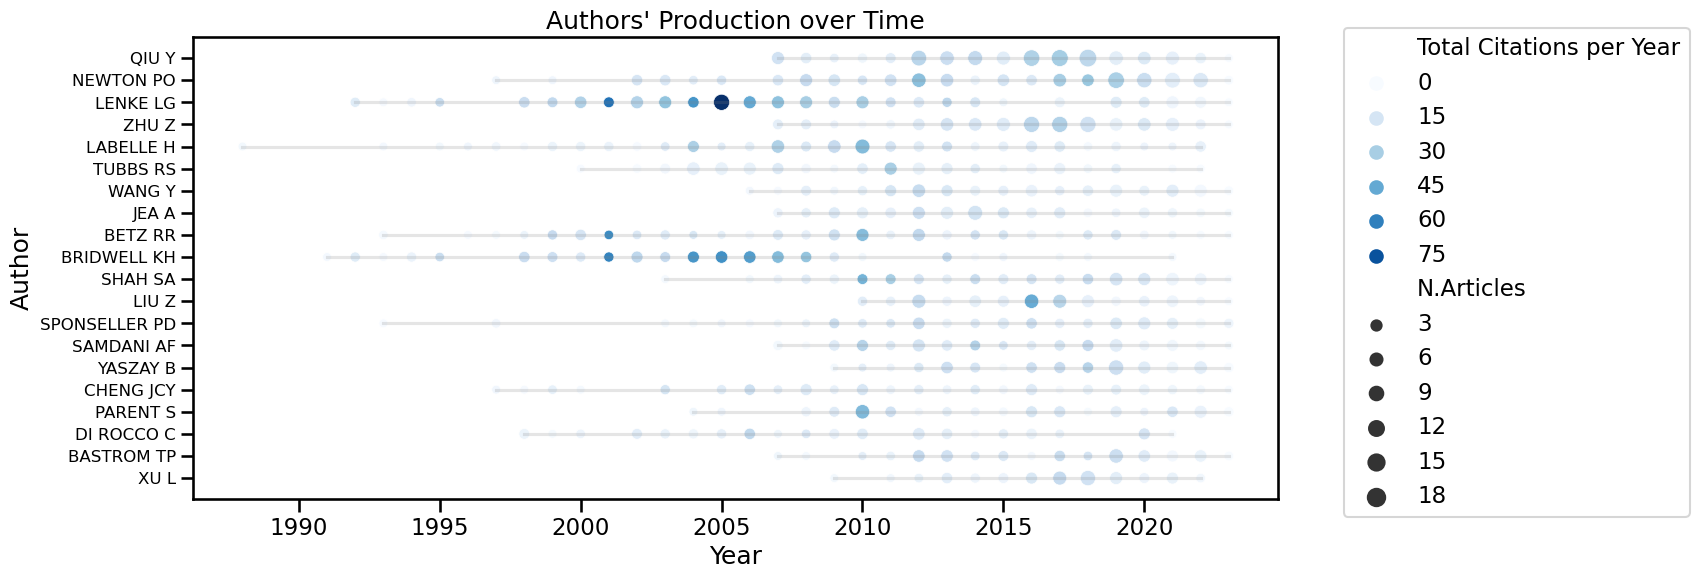

In [18]:
sns.set_context("talk")

# Rename variables
df2.rename(columns={'freq': 'N.Articles', 'TCpY': 'Total Citations per Year', 'year':'Year'}, inplace=True)

fig = plt.figure(figsize=(14, 6))

# Draw scatterplot
scatter = sns.scatterplot(y='Author', x='Year', size='N.Articles', hue='Total Citations per Year', data=df2,palette='Blues')

# Create dataframe for lineplot
df_line = df2.groupby('Author')['Year'].agg(['min', 'max']).reset_index()

# Draw line for each author
for author in df_line['Author']:
    min_year = df_line[df_line['Author'] == author]['min'].values[0]
    max_year = df_line[df_line['Author'] == author]['max'].values[0]
    plt.plot([min_year, max_year], [author, author], color='gray',alpha=.2)

plt.title("Authors' Production over Time")

# Decrease ytick labels size
plt.yticks(fontsize=12)

# Move legend to right
plt.legend(bbox_to_anchor=(1.05, 1.045), loc=2)

plt.show()

## generating the second part of figure 6

In [21]:
author_impact = pd.read_csv("Author_Impact_peds_spine.csv") # this was generated by the biblioshiny app

author_impact = author_impact.loc[:19] # limit to top 20 authors
author_impact

,Element,h_index,g_index,m_index,TC,NP,PY_start
0,LENKE LG,60,107,1.875,11795,149,1992
1,BRIDWELL KH,53,79,1.606,9362,79,1991
2,NEWTON PO,40,56,1.481,4017,156,1997
3,LABELLE H,38,61,1.056,4145,107,1988
4,BETZ RR,33,72,1.065,5219,80,1993
5,AUBIN CE,28,40,1.037,1741,59,1997
6,SHAH SA,28,46,1.333,2302,79,2003
7,CHENG JCY,27,46,1.000,2250,70,1997
8,DI ROCCO C,27,43,1.038,2045,67,1998
9,SAMDANI AF,26,39,1.529,1701,74,2007


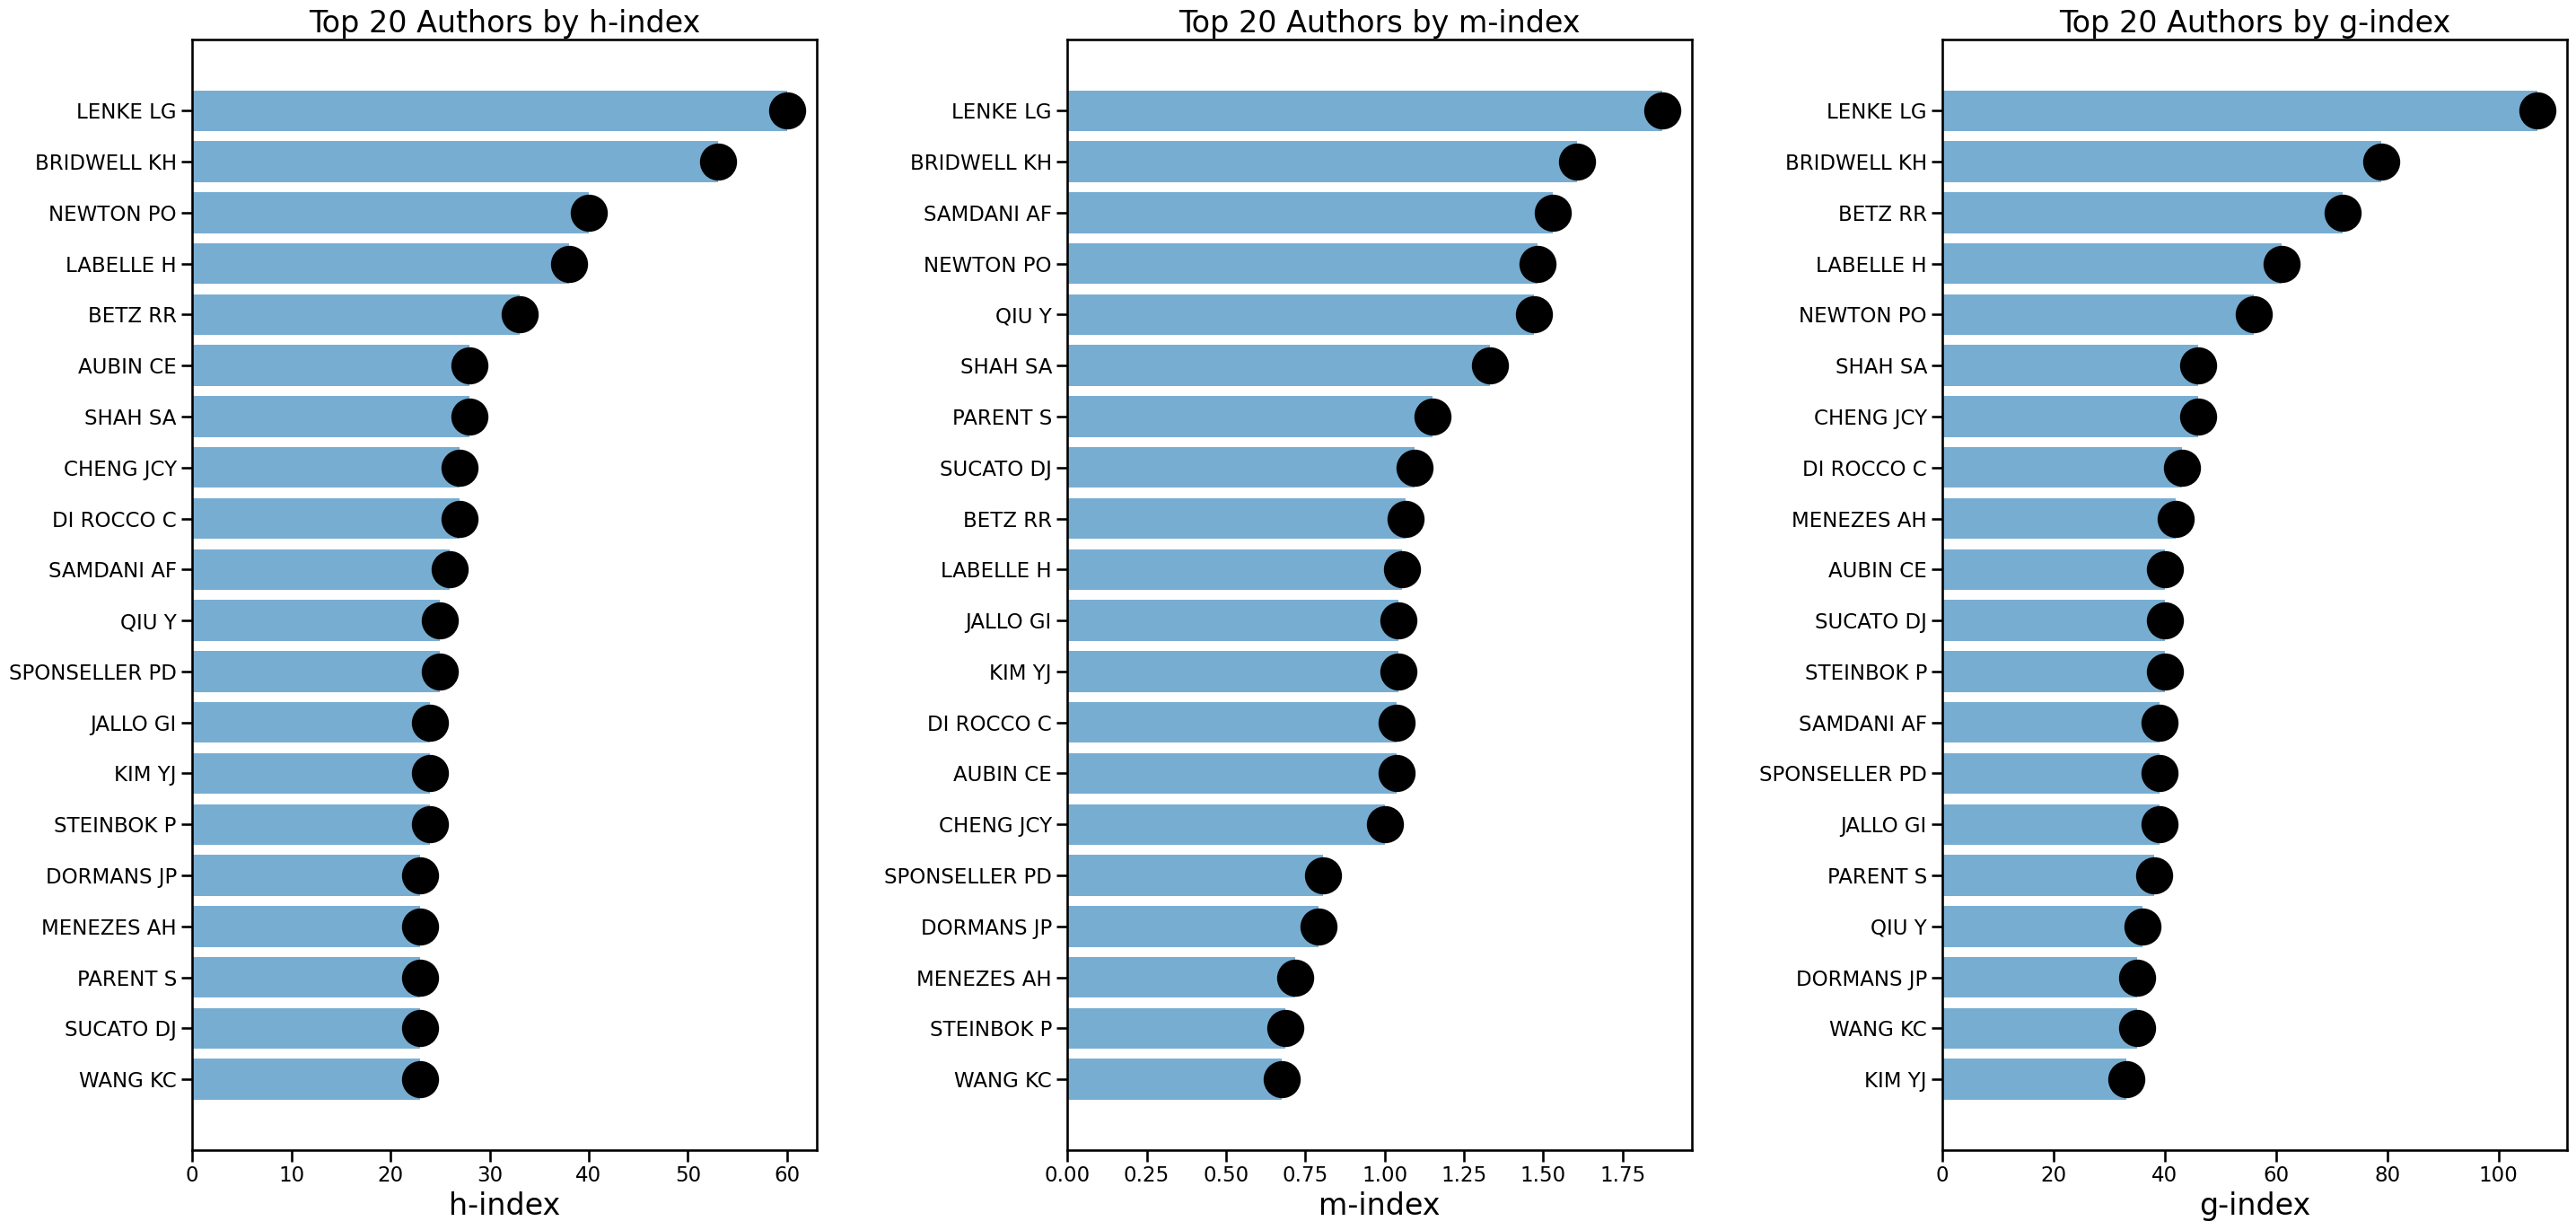

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(30, 15))

dot_width = 800

# Sort the DataFrame by m_index and g_index
author_impact_sorted_m_index = author_impact.sort_values("m_index", ascending=False)
author_impact_sorted_g_index = author_impact.sort_values("g_index", ascending=False)

# Plot h_index
axs[0].barh(y=author_impact["Element"], width=author_impact["h_index"], alpha=0.6)
axs[0].scatter(
    author_impact["h_index"], author_impact["Element"], color="black", s=dot_width
)
axs[0].set_xlabel("h-index", size=24)
axs[0].set_title("Top 20 Authors by h-index", size=24)
axs[0].invert_yaxis()

# Plot m_index
axs[1].barh(
    y=author_impact_sorted_m_index["Element"],
    width=author_impact_sorted_m_index["m_index"],
    alpha=0.6,
)
axs[1].scatter(
    author_impact_sorted_m_index["m_index"],
    author_impact_sorted_m_index["Element"],
    color="black",
    s=dot_width,
)
axs[1].set_xlabel("m-index", size=24)
axs[1].set_title("Top 20 Authors by m-index", size=24)
axs[1].invert_yaxis()

# Plot g_index
axs[2].barh(
    y=author_impact_sorted_g_index["Element"],
    width=author_impact_sorted_g_index["g_index"],
    alpha=0.6,
)
axs[2].scatter(
    author_impact_sorted_g_index["g_index"],
    author_impact_sorted_g_index["Element"],
    color="black",
    s=dot_width,
)
axs[2].set_xlabel("g-index", size=24)
axs[2].set_title("Top 20 Authors by g-index", size=24)
axs[2].invert_yaxis()

# Add some padding between subplots
fig.tight_layout(pad=3.0)

# Display the charts
plt.show()